# Overview

To predict sales for every product and store in the next month I used a two-level model. I trained three models: linear, lightgbm and xgboost. Using convex mix I combine the results to get the final prediction.

__Features__

Data preprocessing steps were largely taken from the lectures and programming assignments from the Coursera "How to Win a Data Science Competition: Learn from Top Kagglers"

1. _Aggregated variables_

   `item_cnt_month` - aggregated sum of sells for seach shop-item pair per month
    
   `target_shop` - aggregated sum of sells for a shop per month
    
   `target_item`  - aggregated sum of sells for an item per month
    
2. _Feature extracted from text_

    `category` - based on the `item_category_name` which were grouped to several categories based on my interpretation of running google translate on the russian names. During modeling `category` variables were encoded with one-hot encoding

2. _Mean encoding_
   
    `item_id_expanding_mean` - used expanding mean scheme to encode `item_id`.

3. _lag variables_
   
   used  `shift_range = [1, 2, 3, 12]`

   `item_cnt_month `,  `item_id_expanding_mean `,  `target_item `,  `target_sho `


__Modeling__

I trained the model only on the shops available in the test set (shops that are not there have been inactive for a long time or had very sporadic sales).  See the plots below.

To predict sales for every product and store in the next month I will use two-level model.

- The first level consists of a __Linear model__ and two gradient boosting ones: __lightgbm__, __xgboos__. Each model uses the same sets of features to predict the dependent varaible __`item_cnt_month`__.  As the result, for each models I got a separate prediction for __`item_cnt_month`__.

- As the second level I enseble the results into one prediction with a convex mix
    $$
    mix= \alpha\cdot\text{linreg_prediction}+\beta\cdot\text{lgb_prediction}+\gamma\cdot\text{lxgboost_prediction}
    $$
    with a constraint $\alpha+\beta+\gamma=1$.

- To determine the coefficients $(\alpha, \beta, \gamma)$ I used KFold scheme in time series, the same strategy as in Coursera assignment *Programming_assignment_week_4*:
    
    1. I trained all three models (__Linear model__, __lightgbm__, __xgboos__) for each `date_block_num = 30, 31, 32, 33` and obtained their corresponding predictins. 
 
    1. I used a simple grid-search to find the optimal value of $(\alpha, \beta, \gamma)$, this gave me the minimal RMSE between __mix__ and __y_train__ (known numer of sell for each item in each shop for given month `item_cnt_month`). This optimal value of $(\alpha, \beta, \gamma)$ was chosen for the final step.

- The final prediction for `date_block_num = 34` was obtained by calculating the prediction from __Linear model__,  __lightgbm__, __xgboost__ trained on data `date_block_num <= 33` and combining them with the convex mix mentioned above with the optimal parameters $(\alpha, \beta, \gamma)$. 


__How to reproduce the results__

At the end of the notebook in section __Prediction for the last month ('date_block_num == 34)__ You can load trained models and necessary data to regenerate submitted results. 



In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook
from sklearn import preprocessing
from itertools import product
import pickle
from joblib import dump, load

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

In [3]:
DATA_FOLDER = './data/'

sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats       = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
submission      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

# Exploratory data analysis

__Time trend for each shop.__

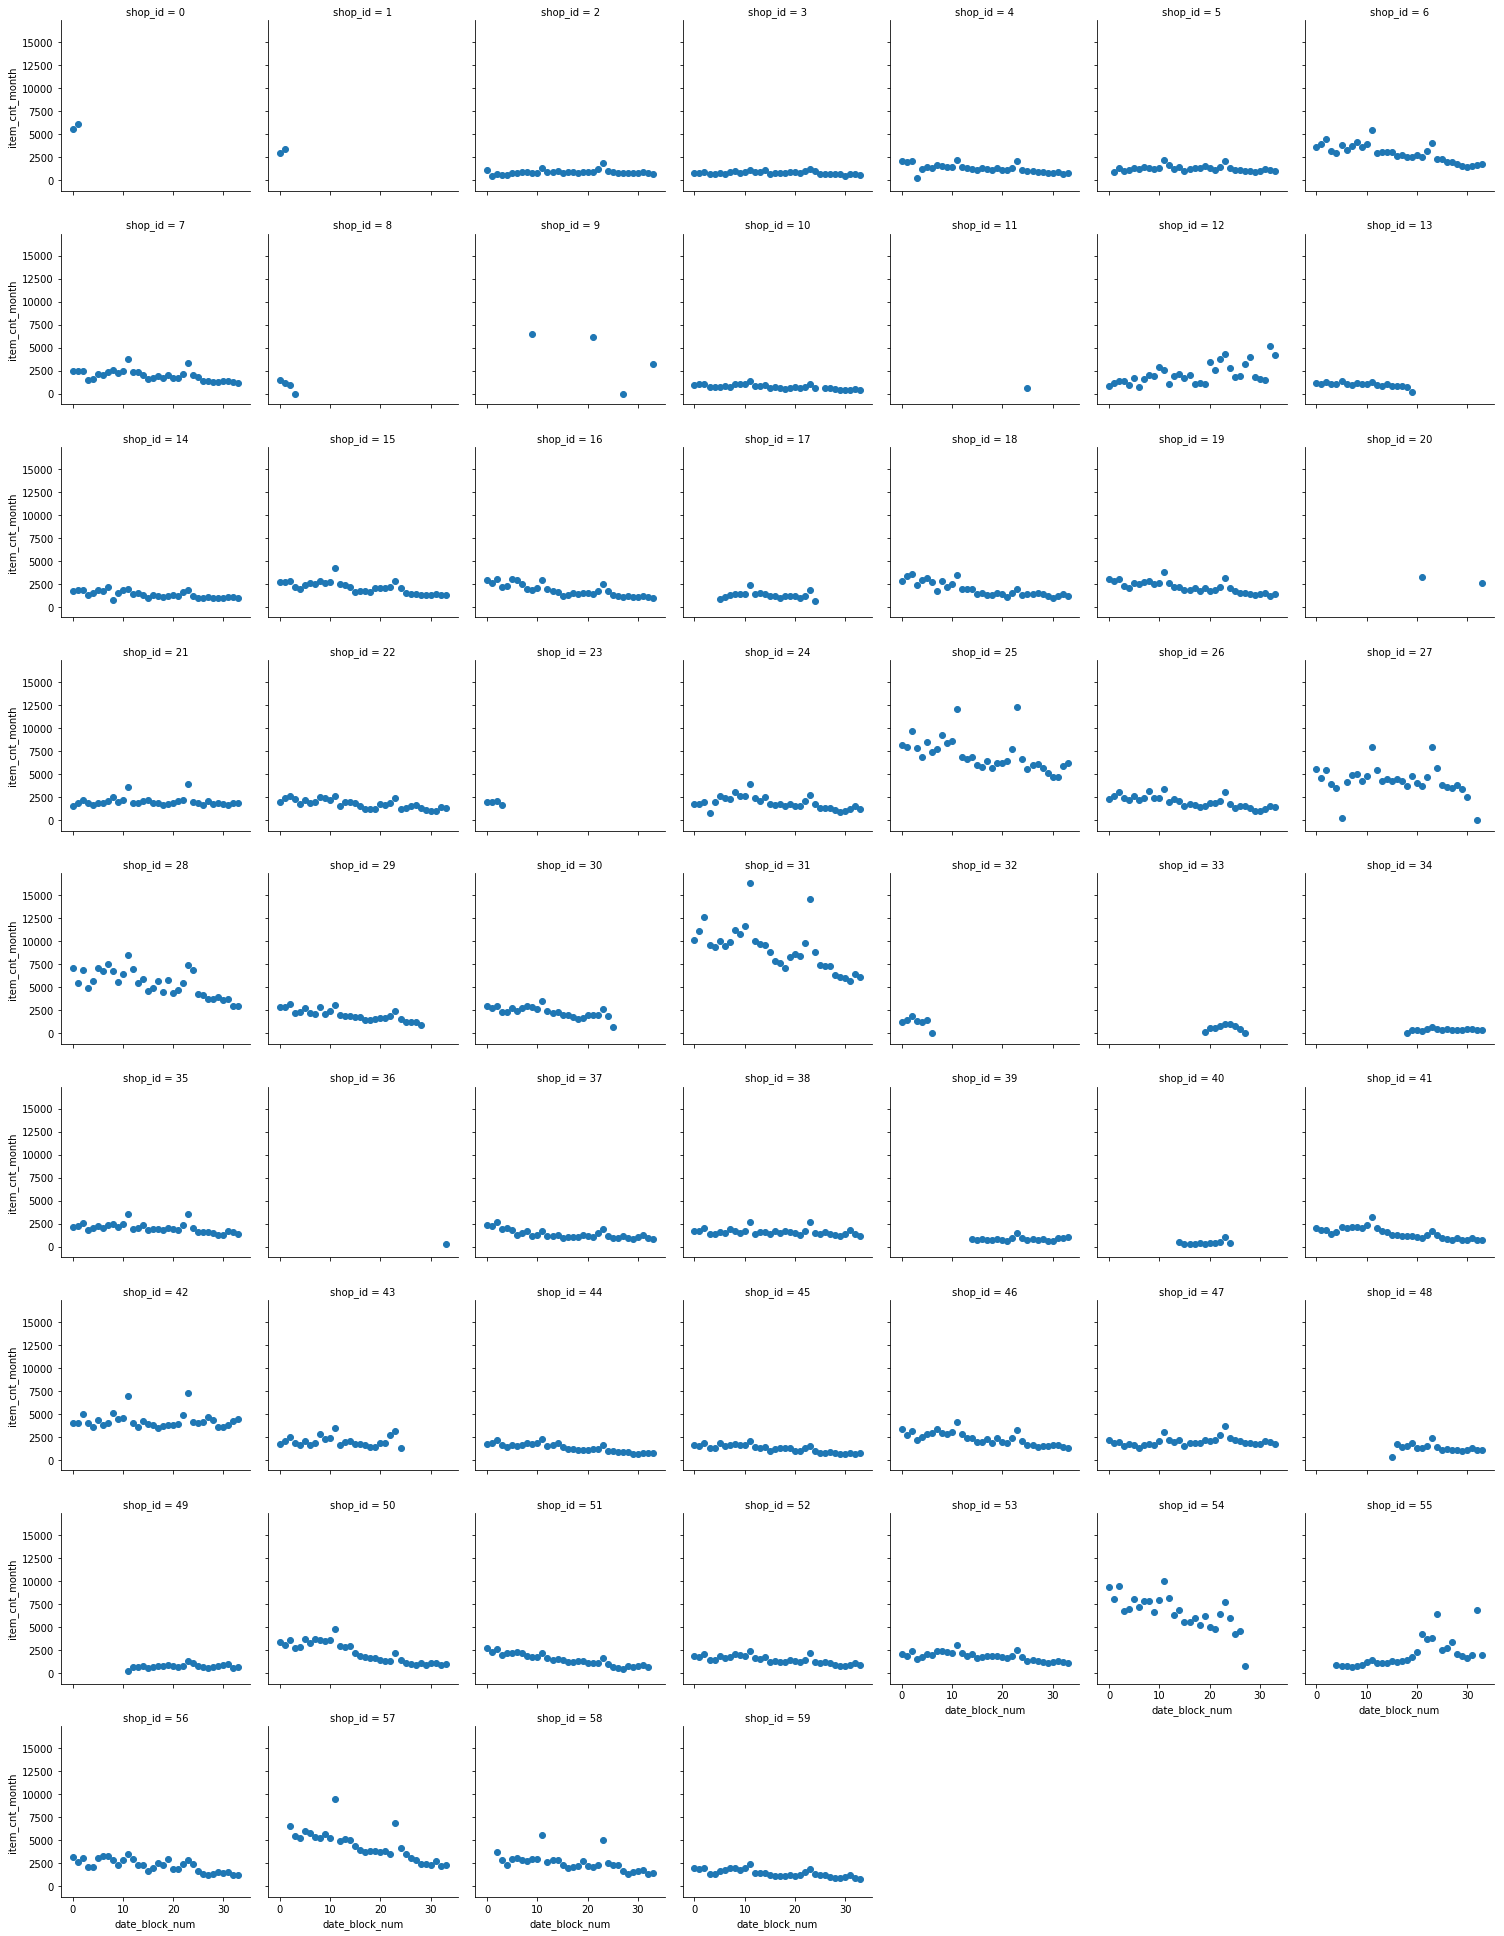

In [3]:
index_cols1 = ['shop_id', 'date_block_num']
gb_cnt = sales.groupby(index_cols1)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
grid = sns.FacetGrid(gb_cnt, col='shop_id', col_wrap=7)
grid.map(plt.scatter, 'date_block_num', 'item_cnt_month')

__Observation__ From some shops there is no current (past ~2 months) history of selling any product. 
In the test set these shops are skipped

__I will train the model only on the shops available in the test set (shops that are not there have been inactive for a long time)__

In [4]:
active_shops = [id for id in test['shop_id'].unique() if id not in [36]]
# Training sets will contain only shops, which are listed in test set. 
sales = sales[sales['shop_id'].isin(active_shops)]

# Feature extraction from text

- Create new variable `category` - based on the `item_category_name` from `item_cats`.
- item_category_names were grouped to several categories (based on google translate). During modeling `category` variables were encoded with one-hot encoding
 

In [5]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
item_cats['category'] = "Other"

cat_to_id = {
    'Accessories': list(range(0,8))+[25],
    'Tickets': [8],
    'Delivery': [9],
    'Consoles': range(10,18),
    'Console Games': range(18,25),
    'Mobile Games': [26],
    'MAC Games': [27],
    'PC Games': range(28,32),
    'Coupons': range(32,37),
    'Movies': range(37,42),
    'Books': range(42,55),
    'Music': range(55,61),
    'Gifts': range(61,73),
    'Software': range(73,79),
    'Service': [79, 80]
}

l_cat = list(item_cats.item_category_name)

for cat, inds in cat_to_id.items():
    for ind in inds:
        item_cats['category'].iloc[ind] = "cat_"+cat
        
#item_cats['category'] = item_cats['category'].astype('category')
item_cats.head()

/home/monika/.local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,cat_Accessories
1,Аксессуары - PS2,1,cat_Accessories
2,Аксессуары - PS3,2,cat_Accessories
3,Аксессуары - PS4,3,cat_Accessories
4,Аксессуары - PSP,4,cat_Accessories


In [7]:
items2 = pd.merge(items ,item_cats, how='left',on='item_category_id').fillna(0)
items2.head()

,item_name,item_id,item_category_id,item_category_name,category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,cat_Movies
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,Программы - Для дома и офиса (Цифра),cat_Software
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,cat_Movies
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,cat_Movies
4,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,cat_Movies


# Feature preprocessing and generation with respect to models

Here I create `train` table from `sales` data frame. `train` contains features aggregated over each month. 

## Feature matrix

- create the grid from all shop/items combinantion for every month
- create variables: 
    - `item_cnt_month` - aggregated sum of sells for seach shop-item pair per month
    - `target_shop` - aggregated sum of sells for a shop per month
    - `target_item` - aggregated sum of sells for an item per month

In [8]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'item_cnt_month':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
train = pd.merge(train, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
train = pd.merge(train, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
train = downcast_dtypes(train)
del grid, gb
gc.collect();

/home/monika/.local/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [9]:
train = pd.merge(train, items2, how='left',on='item_id').fillna(0)
test = pd.merge(test, items2, how='left',on='item_id').fillna(0)

In [10]:
test['date_block_num'] = 34

In [11]:
del test['item_name']
del train['item_name']
del test['item_category_name']
del train['item_category_name']

In [12]:
train.head()

,shop_id,item_id,date_block_num,item_cnt_month,target_shop,target_item,item_category_id,category
0,59,22154,0,1.0,2017.0,16.0,37,cat_Movies
1,59,2552,0,0.0,2017.0,0.0,58,cat_Music
2,59,2554,0,0.0,2017.0,1.0,58,cat_Music
3,59,2555,0,0.0,2017.0,1.0,56,cat_Music
4,59,2564,0,0.0,2017.0,4.0,59,cat_Music


In [13]:
test.head()

,ID,shop_id,item_id,item_category_id,category,date_block_num
0,0,5,5037,19,cat_Console Games,34
1,1,5,5320,55,cat_Music,34
2,2,5,5233,19,cat_Console Games,34
3,3,5,5232,23,cat_Console Games,34
4,4,5,5268,20,cat_Console Games,34


# Advanced Features

## mean encoding: Expanding mean scheme

In [14]:
cumsum = train.groupby('item_id')['item_cnt_month'].cumsum()-train['item_cnt_month']
cumcnt = train.groupby('item_id').cumcount()
train["item_id_expanding_mean"] = cumsum/cumcnt

In [15]:
prior = train["item_cnt_month"].mean()
train['item_id_expanding_mean'].fillna(prior, inplace=True) 

In [16]:
encoded_feature = train['item_id_expanding_mean'].values
print(np.corrcoef(train['item_cnt_month'].values, encoded_feature)[0][1])

0.49286610476208675


## Lag features

In [17]:
all_data = pd.concat([train, test])
all_data = all_data.drop(columns = ['ID'])
all_data = downcast_dtypes(all_data)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
index_cols = ['shop_id', 'item_id', 'item_category_id', 'date_block_num', 'category']
cols_to_rename = list(all_data.columns.difference(index_cols))
cols_to_rename

['item_cnt_month', 'item_id_expanding_mean', 'target_item', 'target_shop']

In [19]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [20]:
all_data.head(5)

,category,date_block_num,item_category_id_x,item_cnt_month,item_id,item_id_expanding_mean,shop_id,target_item,target_shop,item_cnt_month_lag_1,item_id_expanding_mean_lag_1,target_item_lag_1,target_shop_lag_1,item_cnt_month_lag_2,item_id_expanding_mean_lag_2,target_item_lag_2,target_shop_lag_2,item_cnt_month_lag_3,item_id_expanding_mean_lag_3,target_item_lag_3,target_shop_lag_3,item_cnt_month_lag_12,item_id_expanding_mean_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id_y
0,cat_Software,12,76,123.0,492,2.023569,55,123.0,1150.0,92.0,1.767361,92.0,1383.0,128.0,1.542510,128.0,1228.0,70.0,1.555000,70.0,916.0,0.0,0.0,0.0,0.0,76
1,cat_Software,12,78,1.0,490,0.033784,55,1.0,1150.0,0.0,0.000000,0.0,0.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0,78
2,cat_Software,12,78,1.0,488,0.032258,55,1.0,1150.0,1.0,0.028249,1.0,1383.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0,78
3,cat_Books,12,44,1.0,446,0.347985,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,44
4,cat_Books,12,44,1.0,132,0.027027,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,1.0,916.0,0.0,0.0,0.0,0.0,44


In `all_data` contains columns `item_category_id` as `item_category_id_x`, `item_category_id_y`, below I remove the duplicates.

In [21]:
del all_data['item_category_id_y']
all_data = all_data.rename(columns={'item_category_id_x': 'item_category_id'})

In [22]:
all_data.head()

,category,date_block_num,item_category_id,item_cnt_month,item_id,item_id_expanding_mean,shop_id,target_item,target_shop,item_cnt_month_lag_1,item_id_expanding_mean_lag_1,target_item_lag_1,target_shop_lag_1,item_cnt_month_lag_2,item_id_expanding_mean_lag_2,target_item_lag_2,target_shop_lag_2,item_cnt_month_lag_3,item_id_expanding_mean_lag_3,target_item_lag_3,target_shop_lag_3,item_cnt_month_lag_12,item_id_expanding_mean_lag_12,target_item_lag_12,target_shop_lag_12
0,cat_Software,12,76,123.0,492,2.023569,55,123.0,1150.0,92.0,1.767361,92.0,1383.0,128.0,1.542510,128.0,1228.0,70.0,1.555000,70.0,916.0,0.0,0.0,0.0,0.0
1,cat_Software,12,78,1.0,490,0.033784,55,1.0,1150.0,0.0,0.000000,0.0,0.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0
2,cat_Software,12,78,1.0,488,0.032258,55,1.0,1150.0,1.0,0.028249,1.0,1383.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0
3,cat_Books,12,44,1.0,446,0.347985,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,cat_Books,12,44,1.0,132,0.027027,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,1.0,916.0,0.0,0.0,0.0,0.0


## One-Hot encoding

In [23]:
cat_hot = pd.get_dummies(pd.Series(all_data['category']))
all_data = pd.concat([all_data, cat_hot], axis=1, join_axes=[all_data.index])
del all_data['category']

In [24]:
all_data.head()

,date_block_num,item_category_id,item_cnt_month,item_id,item_id_expanding_mean,shop_id,target_item,target_shop,item_cnt_month_lag_1,item_id_expanding_mean_lag_1,target_item_lag_1,target_shop_lag_1,item_cnt_month_lag_2,item_id_expanding_mean_lag_2,target_item_lag_2,target_shop_lag_2,item_cnt_month_lag_3,item_id_expanding_mean_lag_3,target_item_lag_3,target_shop_lag_3,item_cnt_month_lag_12,item_id_expanding_mean_lag_12,target_item_lag_12,target_shop_lag_12,Other,cat_Accessories,cat_Books,cat_Console Games,cat_Consoles,cat_Coupons,cat_Delivery,cat_Gifts,cat_MAC Games,cat_Mobile Games,cat_Movies,cat_Music,cat_PC Games,cat_Service,cat_Software,cat_Tickets
0,12,76,123.0,492,2.023569,55,123.0,1150.0,92.0,1.767361,92.0,1383.0,128.0,1.542510,128.0,1228.0,70.0,1.555000,70.0,916.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,12,78,1.0,490,0.033784,55,1.0,1150.0,0.0,0.000000,0.0,0.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,12,78,1.0,488,0.032258,55,1.0,1150.0,1.0,0.028249,1.0,1383.0,1.0,0.029412,1.0,1228.0,1.0,0.033708,1.0,916.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,12,44,1.0,446,0.347985,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,44,1.0,132,0.027027,55,1.0,1150.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,1.0,916.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### save all data



In [25]:
all_data.to_hdf("all_data.h5", "all_data")


__If I am not changed anything in the preprecessing steps I load all_data from file.__

In [ ]:
# all_data = pd.read_hdf("all_data.h5", "all_data")

# Modeling

I trained the model only on the shops available in the test set (shops that are not there have been inactive for a long time or had very sporadic sales).  See the plots below.

To predict sales for every product and store in the next month I will use two-level model.

- The first level consists of a __Linear model__ and two gradient boosting ones: __lightgbm__, __xgboos__. Each model uses the same sets of features to predict the dependent varaible __`item_cnt_month`__.  As the result, for each models I got a separate prediction for __`item_cnt_month`__.

- As the second level I enseble the results into one prediction with a convex mix
    $$
    mix= \alpha\cdot\text{linreg_prediction}+\beta\cdot\text{lgb_prediction}+\gamma\cdot\text{lxgboost_prediction}
    $$
    with a constraint $\alpha+\beta+\gamma=1$.

- To determine the coefficients $(\alpha, \beta, \gamma)$ I used KFold scheme in time series, the same strategy as in Coursera assignment *Programming_assignment_week_4*:
    
    1. I trained all three models (__Linear model__, __lightgbm__, __xgboos__) for each `date_block_num = 30, 31, 32, 33` and obtained their corresponding predictins. 
 
    1. I used a simple grid-search to find the optimal value of $(\alpha, \beta, \gamma)$, this gave me the minimal RMSE between __mix__ and __y_train__ (known numer of sell for each item in each shop for given month `item_cnt_month`). This optimal value of $(\alpha, \beta, \gamma)$ was chosen for the final step.

- The final prediction for `date_block_num = 34` was obtained by calculating the prediction from __Linear model__,  __lightgbm__, __xgboost__ trained on data `date_block_num <= 33` and combining them with the convex mix mentioned above with the optimal parameters $(\alpha, \beta, \gamma)$. 

Below the following steps are presented:

- __Function declarations__ functions used during modeling 
    -  `split_train_test` - splitting data into train and test set
    
    - `fit_linear`, `fit_lgb`, `fit_xboost` - functions to train the data - linear, lbg and xboost models takes the same variables (X_train, y_train) as the input
    
    - `rmse_clip` - function to calculate RMSE. The same validation were used in Kaggle competition. Before calculating RMSE, the values were clip(0, 20) 

- __Preliminary tests__ validate linear, lbg and xboost models based on the `date_block_num = 33`. Test the three models independently to see if they generate useful predictions (make validation based on RMSE score)

- __Ensembles__ find the optimal `alpha`, `beta`, `gamma`. Used  KFold scheme in time series.

- __First level modeling__ -  Predict the __`item_cnt_month`__ for `date_block_num = 34` using linear, lbg and xboost 

- __Second level modeling__ - Combine the results using linear convex mix with found optimal parameters `alpha`, `beta`, `gamma`. Create the final predictions, which were submitted. 

__Function declarations__

In [8]:
def split_train_test(all_data, test_block):
    dates = all_data['date_block_num']
    
    train_idx = dates < test_block
    test_idx = dates == test_block
    
    dates_train = dates[train_idx]
    dates_test  = dates[test_idx]
    
    X_train = all_data.loc[train_idx].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[test_idx].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[train_idx, 'item_cnt_month'].values
    
    if test_block < 34:
        y_test =  all_data.loc[test_idx, 'item_cnt_month'].values
    else:
        y_test = []
        
    return X_train, X_test, y_train, y_test

def fit_linear(X_train, y_train, X_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    return pred_lr

def fit_lgb(X_train, y_train, X_test, params):
    model = lgb.train(params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    return pred_lgb

def fit_xboost(X_train, y_train, X_test, param_xboost):
    xgbtrain = xgb.DMatrix(X_train,y_train)
    bst = xgb.train(param_xboost, xgbtrain)
    xgbpredict = xgb.DMatrix(X_test)
    pred_xboost = bst.predict(xgbpredict)
    return pred_xboost

def combine_lin_lgb(pred_lr, pred_lgb, pred_xboost):
    return np.c_[pred_lr, pred_lgb, pred_xboost] 

def rmse_clip(y_test, pred):
    return np.sqrt(((y_test.clip(0, 20)-pred.clip(0, 20))**2).mean())

Parameters used for the gradient boosting models

In [28]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1, 
    'min_data_in_leaf': 2**7, 
    'bagging_fraction': 0.75, 
    'learning_rate': 0.03, 
    'objective': 'mse', 
    'bagging_seed': 2**7, 
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0
}

In [29]:
param_xboost = {
    'max_depth':10,
    'subsample':1,
    'min_child_weight':0.5,
    'eta':0.3, 
    'num_round':1000, 
    'seed':1,
    'silent':0,
    'nthread':1,
    'eval_metric':'rmse',
} 

## Preliminary tests

Below we test the three models independently to see if they generate useful predictions.  This section is for initial tests only and the results from here will not be used in the final model.

__Below three model are tested - Linear model, LightGBM, Xgboost__

Models are trained on data with `data_block_num <= 32` and validated on `data_block_num = 33` by calculating RMSE of their predictions. The best results were obtained. 

In [32]:
X_train, X_test, y_train, y_test = split_train_test(all_data, 33)

### Linear model

In [33]:
pred_lr = fit_linear(X_train, y_train, X_test)
print('Test RMSE for linreg is %f' % rmse_clip(y_test, pred_lr))

Test RMSE for linreg is 0.939884


### LightGBM

In [34]:
pred_lgb = fit_lgb(X_train, y_train, X_test, lgb_params)
print('Test RMSE for LightGBM is %f' % rmse_clip(y_test, pred_lgb))

Test RMSE for LightGBM is 0.913609


## Xgboost

In [35]:
pred_xboost = fit_xboost(X_train, y_train, X_test, param_xboost)
print('Test RMSE for Xgboost is %f' % rmse_clip(y_test, pred_xboost))

[20:21:15] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[20:22:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=10
[20:22:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=10
[20:23:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 876 extra nodes, 0 pruned nodes, max_depth=10
[20:23:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=10
[20:24:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 0 pruned nodes, max_depth=10
[20:25:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 900 extra nodes, 0 pruned nodes, max_depth=10
[20:25:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 root

## Conclusions

The best prediction was obtained for XgBoost  (RMSE 0.857). However, the other two models also characterized with low RMSE. 
Therefore, in the next steps, all three models will be used to obtain the final prediction.

# Ensembles

- Train three models on data using  `data_block_num` from 30 to 33

- Save the prediciton for linear model, lbg and Xgboost as `X_train_level2`

- Save the true y values as `y_train_level2`

- Then find the optimal way to combine the results from three models into one. Here we used the linear convex mix.
$$
mix= \alpha\cdot\text{linreg_prediction}+\beta\cdot\text{lgb_prediction}+\gamma\cdot\text{lxgboost_prediction}
$$

In [36]:
x_train_level2_ = []
y_train_level2_ = []
months_K = list(range(30,34))


for cur_block_num in months_K:
    
    print(cur_block_num)
    X_train, X_test, y_train, y_test = split_train_test(all_data, cur_block_num)
    pred_lr = fit_linear(X_train, y_train, X_test)
    print('Test RMSE for linreg is %f' % rmse_clip(y_test, pred_lr))
    pred_lgb = fit_lgb(X_train, y_train, X_test, lgb_params)
    print('Test RMSE for LightGBM is %f' % rmse_clip(y_test, pred_lgb))
    pred_xboost = fit_xboost(X_train, y_train, X_test, param_xboost)
    print('Test RMSE for Xgboost is %f' % rmse_clip(y_test, pred_xboost))
    x_train_level2_.append(combine_lin_lgb(pred_lr, pred_lgb, pred_xboost))
    y_train_level2_.append(y_test)

X_train_level2 = np.vstack(x_train_level2_[:-1])
y_train_level2 = np.concatenate(y_train_level2_[:-1])

30
Test RMSE for linreg is 0.800700
Test RMSE for LightGBM is 0.742306
[20:29:14] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[20:29:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=10
[20:30:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1034 extra nodes, 0 pruned nodes, max_depth=10
[20:30:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 988 extra nodes, 0 pruned nodes, max_depth=10
[20:31:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[20:32:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=10
[20:32:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=10
[20:

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

We will use a convex mix of three predictions

$$
mix = \alpha\cdot\text{linreg_prediction}+\beta\cdot\text{lgb_prediction}+\gamma\cdot\text{lxgboost_prediction}
$$

with $\alpha+\beta+\gamma=1$

We find the best combination of $\alpha, \beta, \gamma$ by grid-searching the parameter space for the minimum of RMSE.

In [37]:
def error_mix(alpha, beta, x, y):
    mix = alpha*x[:,0]+beta*x[:,1]+(1-alpha-beta)*x[:,2]
    return rmse_clip(y, mix)

In [38]:
alpha_beta = np.array([(x,y) for x in np.linspace(0,1,30) for y in np.linspace(0,1,30)])
err = np.array([error_mix(a, b, X_train_level2, y_train_level2) for a,b in alpha_beta])

In [39]:
alpha, beta = alpha_beta[err.argmin(),:]
gamma = (1-alpha-beta)

After finding the optimal combination of `[alpha, beta, gamma]` we use them to combine the final prediction for `date_block_num == 34`

In [40]:
[alpha, beta, gamma]

[0.13793103448275862, 0.27586206896551724, 0.5862068965517241]

# Prediction for the last month ('date_block_num == 34')






In [4]:
all_data = pd.read_hdf("all_data.h5", key="all_data")

In [5]:
to_drop_cols = ['item_cnt_month', 'target_shop',  'item_id_expanding_mean',  'target_item',  'date_block_num']

##  First level modeling

We fit all the models again to data from months < 34 and combine them based on the optimal mixing coefficients that we found above.

In [6]:
all_data.query('date_block_num == 34').head()

,date_block_num,item_category_id,item_cnt_month,item_id,item_id_expanding_mean,shop_id,target_item,target_shop,item_cnt_month_lag_1,item_id_expanding_mean_lag_1,target_item_lag_1,target_shop_lag_1,item_cnt_month_lag_2,item_id_expanding_mean_lag_2,target_item_lag_2,target_shop_lag_2,item_cnt_month_lag_3,item_id_expanding_mean_lag_3,target_item_lag_3,target_shop_lag_3,item_cnt_month_lag_12,item_id_expanding_mean_lag_12,target_item_lag_12,target_shop_lag_12,Other,cat_Accessories,cat_Books,cat_Console Games,cat_Consoles,cat_Coupons,cat_Delivery,cat_Gifts,cat_MAC Games,cat_Mobile Games,cat_Movies,cat_Music,cat_PC Games,cat_Service,cat_Software,cat_Tickets
5239624,34,19,0.0,5037,0.0,5,0.0,0.0,0.0,2.008897,25.0,1052.0,1.0,2.05973,110.0,1092.0,3.0,2.035491,117.0,1294.0,1.0,2.524272,53.0,1445.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5239625,34,55,0.0,5320,0.0,5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5239626,34,19,0.0,5233,0.0,5,0.0,0.0,1.0,1.710145,41.0,1052.0,3.0,1.78970,80.0,1092.0,1.0,1.683938,149.0,1294.0,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5239627,34,23,0.0,5232,0.0,5,0.0,0.0,0.0,1.151786,27.0,1052.0,0.0,1.42029,48.0,1092.0,1.0,1.689655,64.0,1294.0,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5239628,34,20,0.0,5268,0.0,5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Split data into train, test set. 
Here `y_test` is unknown and has to be predicted

In [9]:
X_train, X_test, y_train, y_test = split_train_test(all_data, 34)

In [10]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':1, 
    'min_data_in_leaf': 2**7, 
    'bagging_fraction': 0.75, 
    'learning_rate': 0.03, 
    'objective': 'mse', 
    'bagging_seed': 2**7, 
    'num_leaves': 2**7,
    'bagging_freq':1,
    'verbose':0
}

In [11]:
param_xboost = {
    'max_depth':10,
    'subsample':1,
    'min_child_weight':0.5,
    'eta':0.3, 
    'num_round':1000, 
    'seed':1,
    'silent':0,
    'nthread':1,
    'eval_metric':'rmse',
} 

__Linear model__

In [12]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# dump(lr, 'linear_model.joblib')
lr = load('linear_model.joblib')
pred_lr = lr.predict(X_test)

__LightGBM__

In [14]:
#lBGM = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
#pred_lgb = lBGM.predict(X_test)
#dump(lBGM, 'lightGBM_model.joblib') 
lBGM = load('lightGBM_model.joblib')
pred_lgb = lBGM.predict(X_test)

__Xgboost__

In [15]:
#xgbtrain = xgb.DMatrix(X_train,y_train)
#bst = xgb.train(param_xboost, xgbtrain)
#dump(bst, 'XGB_model.joblib') 
bst = load('XGB_model.joblib')
pred_xboost = bst.predict(xgb.DMatrix(X_test))

__Combine models__

In [16]:
y_test = combine_lin_lgb(pred_lr, pred_lgb, pred_xboost)
y_test

array([[ 0.63059109,  0.52452431,  0.46409255],
       [ 0.09195619,  0.17425203,  0.22695488],
       [ 0.97314211,  0.78262222,  0.79841536],
       ...,
       [ 0.06889791,  0.05429596,  0.05450681],
       [ 0.10568905,  0.04997614,  0.03974232],
       [-0.01608229,  0.05443045,  0.0432528 ]])

## Second level modeling


__the best parameters [alpha, beta, gamma]__

In [17]:
alpha, beta, gamma =[0.13793103448275862, 0.27586206896551724, 0.5862068965517241]

In [18]:
prediction = alpha*y_test[:,0]+beta*y_test[:,1]+gamma*y_test[:,2]
prediction

array([0.5037287 , 0.19379565, 0.81815887, ..., 0.05643362, 0.05166154,
       0.03815214])

In [19]:
prediction = prediction.clip(0, 20)


__Submission__

In [20]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': prediction })

In [21]:
sub_df.head()

,ID,item_cnt_month
0,0,0.503729
1,1,0.193796
2,2,0.818159
3,3,0.387965
4,4,3.577553


In [66]:
sub_df.to_csv('01_Final_project_Coursera_meta_linear_lgb_xgboost.csv',index=False)